In [1]:
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm
import pathlib
import multiprocessing as mp
import itertools

import time
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'D:\GitHub_Public\Uncertainty_in_Spatial_Accessibility')
import utils

tqdm.pandas()

data_path = pathlib.Path(r'./sample_data')
csv_path = data_path.joinpath('traffic_data', 'modified_csv')
shp_path = data_path.joinpath('traffic_data', 'shp')
result_path = pathlib.Path(r'./result')
processor_num = 4

assert data_path
assert result_path

C:\Users\zawoon96\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Import mobility-related files
file_names = pd.read_csv(data_path.joinpath('traffic_data', 'file_names.txt'), header=None)
original_nodes = gpd.read_file(shp_path.joinpath('nodes.shp'))
merged_edge = utils.road_network_with_uncertainty(file_names, data_path)
G = utils.construct_network(merged_edge, original_nodes)
G = utils.remove_uncenessary_nodes(G)

100%|█████████████████████████████████████████████████████████████████████████| 47260/47260 [00:04<00:00, 11411.04it/s]


Removed 1321 nodes (0.0288%) from the OSMNX network
Number of nodes: 45939
Number of edges: 70698


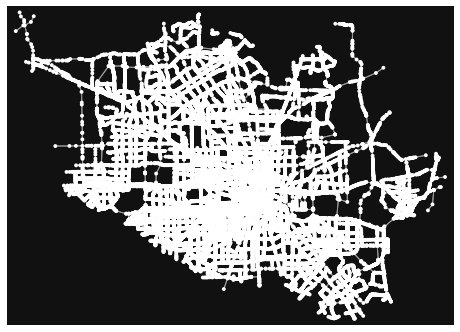

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
import osmnx as ox
ox.plot_graph(G)

In [4]:
# Load ICU bed availability data
xls_file = pd.read_csv(data_path.joinpath('hospital_availability.csv'))
xls_file = xls_file.loc[xls_file['County'] == f'Harris']
xls_file = xls_file.set_index('Date')

# Percentage of available ICU beds per day
avail_ICU = pd.DataFrame(index=xls_file.index, columns=['av_ICU'])
avail_ICU['av_ICU'] = xls_file.apply(lambda x: (x['Avail_ICU'] + x['COV_S_ICU'] + x['COV_C_ICU']) / 1614, axis=1)

# Calculate the percentage of how many percentage of ICU beds are available
probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
supply_prob = pd.DataFrame(index=['av_ratio'], columns=probs)
for idx, val in enumerate(probs):
    if idx == len(probs) - 1:
        break

    supply_prob.loc['av_ratio', probs[idx+1]] = avail_ICU.loc[(avail_ICU['av_ICU'] >= val) & (avail_ICU['av_ICU'] < probs[idx +1])].shape[0]
    supply_prob[val] = supply_prob[val].astype(float)

supply_prob = supply_prob / 153 # 153 days
supply_prob = supply_prob.drop(columns=[0.0])
supply_prob = supply_prob.round(decimals=2)  
supply_prob


,0.2,0.4,0.6,0.8,1.0
av_ratio,0.17,0.61,0.22,0.0,0


In [5]:
# Import supply (ICU beds) and demand (residential population)
supply = gpd.read_file(data_path.joinpath('supply_sample.shp'))
supply = supply.set_index('SupplyID')
supply = supply.loc[supply['ADULT_ICU_'] != 0]
supply

,OBJECTID,HOSPITAL_N,HOSPITAL_T,HQ_ADDRESS,HQ_ADDRE_1,HQ_CITY,HQ_STATE,HQ_ZIP_COD,COUNTY_NAM,STATE_NAME,...,NUM_STAFFE,NUM_ICU_BE,ADULT_ICU_,PEDI_ICU_B,BED_UTILIZ,Potential_,AVG_VENTIL,Ori_Lng,Ori_Lat,geometry
SupplyID,,,,,,,,,,,,,,,,,,,,,
S009,3677.0,TOPS Surgical Specialty Hospital,Short Term Acute Care Hospital,17080 Red Oak Dr,None,Houston,TX,77090,Harris,Texas,...,15.0,3.0,3.0,0.0,0.255890,0.0,0.0,-95.443344,30.018616,POINT (-95.44401 30.01866)
S011,3679.0,Michael E DeBakey VA Medical Center,VA Hospital,2002 Holcombe Blvd,None,Houston,TX,77030,Harris,Texas,...,350.0,2.0,2.0,0.0,0.000000,0.0,2.0,-95.388980,29.700020,POINT (-95.38897 29.70010)
S012,3680.0,Houston Methodist Clear Lake Hospital (FKA Hou...,Short Term Acute Care Hospital,18300 Saint John Dr,None,Houston,TX,77058,Harris,Texas,...,178.0,14.0,14.0,0.0,0.419501,0.0,4.0,-95.086253,29.550134,POINT (-95.08671 29.54938)
S013,3681.0,Memorial Hermann Northeast Hospital,Short Term Acute Care Hospital,18951 N Memorial Dr,None,Humble,TX,77338,Harris,Texas,...,242.0,24.0,24.0,6.0,0.659323,0.0,9.0,-95.275966,29.995399,POINT (-95.27608 29.99565)
S014,3682.0,The Womans Hospital of Texas,Short Term Acute Care Hospital,7600 Fannin St,None,Houston,TX,77054,Harris,Texas,...,257.0,4.0,4.0,0.0,0.500634,162.0,4.0,-95.402064,29.692992,POINT (-95.40206 29.69299)
S015,3683.0,Memorial Hermann Memorial City Medical Center,Short Term Acute Care Hospital,921 Gessner Rd,None,Houston,TX,77024,Harris,Texas,...,444.0,60.0,60.0,24.0,0.513588,0.0,11.0,-95.545897,29.781132,POINT (-95.54690 29.78131)
S016,3684.0,HCA Houston Healthcare Clear Lake (FKA Clear L...,Short Term Acute Care Hospital,500 Medical Center Blvd,None,Webster,TX,77598,Harris,Texas,...,506.0,86.0,86.0,0.0,0.777021,26.0,23.0,-95.127796,29.541099,POINT (-95.12717 29.54089)
S017,3685.0,HCA Houston Healthcare Medical Center (FKA Par...,Short Term Acute Care Hospital,1313 Hermann Dr,None,Houston,TX,77004,Harris,Texas,...,133.0,14.0,14.0,0.0,0.372685,311.0,3.0,-95.387543,29.722720,POINT (-95.38754 29.72272)
S018,3686.0,HCA Houston Healthcare Tomball (FKA Tomball Re...,Short Term Acute Care Hospital,605 Holderrieth Blvd,None,Tomball,TX,77375,Harris,Texas,...,194.0,20.0,20.0,7.0,0.551673,156.0,7.0,-95.623617,30.087405,POINT (-95.62362 30.08740)


In [6]:
demand = gpd.read_file(data_path.joinpath('demand_sample.shp'))
demand = demand.set_index('GRID_ID')
demand = demand.loc[demand['Note'] != 'water']
demand

,OBJECTID_1,Note,Shape_Leng,Shape_Area,Pop,geometry
GRID_ID,,,,,,
BB-41,812,None,10590.959994,8.095059e+06,10038.0,"POLYGON ((-95.16796 29.51484, -95.17757 29.501..."
BC-41,813,None,10590.960394,8.095060e+06,4597.0,"POLYGON ((-95.14118 29.50027, -95.15079 29.486..."
BD-41,814,None,10590.959994,8.095059e+06,3233.0,"POLYGON ((-95.11336 29.51326, -95.12298 29.499..."
BE-41,815,None,10590.960394,8.095060e+06,9921.0,"POLYGON ((-95.08659 29.49868, -95.09621 29.485..."
AZ-40,867,None,10590.960340,8.095060e+06,7536.0,"POLYGON ((-95.22154 29.54397, -95.23115 29.530..."
...,...,...,...,...,...,...
BE-18,2400,None,10590.960740,8.095061e+06,237.0,"POLYGON ((-95.06217 30.13275, -95.07186 30.119..."
AM-17,2437,None,10590.960340,8.095060e+06,5636.0,"POLYGON ((-95.55565 30.17389, -95.56528 30.160..."
AO-17,2439,None,10590.960340,8.095060e+06,8519.0,"POLYGON ((-95.50070 30.17247, -95.51033 30.158..."


In [7]:
# Find nearest node of OSM from supply and demand locations
supply = utils.find_nearest_osm(G, supply)
demand = utils.find_nearest_osm(G, demand)

100%|████████████████████████████████████████████████████████████████████████████████| 644/644 [00:25<00:00, 25.71it/s]


In [8]:
import utils

# Set threshold travel time and corresponding spatial impedance
# minutes = [10, 20, 30]
minutes = [10]
weights = {10: 1, 20: 0.68, 30: 0.22}

# Measure accessibility with multiprocessing package
start = int(time.time())
pool = mp.Pool(processes = processor_num)
access_result = pool.map(utils.measure_accessibility_unpacker, 
                         zip(range(processor_num), 
                             itertools.repeat(supply), 
                             itertools.repeat(demand), 
                             itertools.repeat(supply_prob), 
                             itertools.repeat(file_names), 
                             itertools.repeat(original_nodes), 
                             itertools.repeat(minutes), 
                             itertools.repeat(weights), 
                             itertools.repeat(data_path), 
                             itertools.repeat(result_path)
                            )
                        )
end = int(time.time())
pool.close()
print("***run time(sec) : ", end-start)    


***run time(sec) :  77


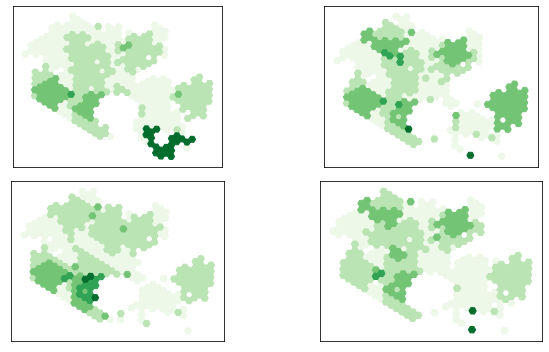

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os


plt_cls = [0, 5, 10, 15, 20, 25]
colors = ['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']

fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    temp_result = gpd.read_file(f'./result/iter_{i}/demand.geojson')
    
    for idx, cls in enumerate(plt_cls):
        if idx == 0: continue
        temp_cls = temp_result.loc[(plt_cls[idx-1] < temp_result[f'step2']) & (temp_result[f'step2'] <= cls)]
        if temp_cls.shape[0] > 0:
            temp_cls.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
            
plt.tight_layout()
plt.show()
